In [5]:
#import necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [6]:
#load mnist dataset
transform = transforms.Compose(
    [transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))])  
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                        download=True, transform=transform)
batch_size = 64
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                            shuffle=True, drop_last=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                            shuffle=False, drop_last=True)

In [7]:
def to_categorical(y, num_classes):
    """ 1-hot encodes a tensor """
    return F.one_hot(y, num_classes)

In [8]:
y = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
y = to_categorical(y, 10)
print(y)

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])


In [14]:
y = torch.randint(0, 10, (10,))
print(y)
y = to_categorical(y, 10)
print(y)

tensor([1, 4, 7, 3, 2, 6, 8, 7, 0, 9])
tensor([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])


In [15]:
#infoGAN Generator
class Generator(nn.Module):
    def __init__(self, latent_dim, n_classes, code_dim):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.n_classes = n_classes
        self.code_dim = code_dim
        input_dim = latent_dim + n_classes + code_dim
        img_size = 28
        self.init_size = img_size // 4
        self.l1 = nn.Sequential(
            nn.Linear(input_dim, 128 * self.init_size ** 2)
        )
        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 1, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, noise, labels, code):
        gen_input = torch.cat((noise, labels, code), -1)
        img = self.l1(gen_input)
        img = img.view(img.size(0), 128, self.init_size, self.init_size)
        img = self.conv_blocks(img)
        return img

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [21]:
latent_dim = 100
n_classes = 10
code_dim = 5
generator = Generator(latent_dim, n_classes, code_dim).to(device)

In [22]:
noise = torch.randn(64, latent_dim).to(device)
labels = torch.randint(0, 10, (64,)).to(device)
labels = to_categorical(labels, n_classes).to(device)
code = torch.randn(64, code_dim).to(device)
print(noise.shape, labels.shape, code.shape)
gen_out = generator(noise, labels, code)
print(gen_out.shape)

torch.Size([64, 100]) torch.Size([64, 10]) torch.Size([64, 5])
torch.Size([64, 1, 28, 28])


In [23]:
#Discriminator
class Discriminator(nn.Module):
    def __init__(self, n_classes, code_dim):
        super(Discriminator, self).__init__()
        self.n_classes = n_classes
        self.code_dim = code_dim
        img_size = 28
        ds_size = img_size // 4
        self.model = nn.Sequential(
            nn.Conv2d(1, 16, 3, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(16, 32, 3, 2, 1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 64, 3, 2, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
        )
        out = 1024
        self.adv_layer = nn.Sequential(nn.Linear(out, 1))
        self.aux_layer = nn.Sequential(nn.Linear(out, n_classes))
        self.code_layer = nn.Sequential(nn.Linear(out, code_dim))

    def forward(self, img):
        out = self.model(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)
        label = self.aux_layer(out)
        code = self.code_layer(out)
        return validity, label, code

In [24]:
discriminator = Discriminator(n_classes, code_dim).to(device)
disc_out = discriminator(gen_out)
print(disc_out[0].shape, disc_out[1].shape, disc_out[2].shape)

torch.Size([64, 1]) torch.Size([64, 10]) torch.Size([64, 5])


In [25]:
#loss functions
adversarial_loss = torch.nn.MSELoss()
auxiliary_loss = torch.nn.CrossEntropyLoss()
continuous_loss = torch.nn.MSELoss()

#optimizer
lr = 0.0002
b1 = 0.5
b2 = 0.999  
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

In [26]:
#training
n_epochs = 50
for epoch in range(n_epochs):
    for i, (imgs, real_labels ) in enumerate(trainloader):
        batch_size = imgs.shape[0]
        imgs = imgs.to(device)
        real_labels = real_labels.to(device)
        real_labels = to_categorical(real_labels, n_classes).to(device)
        #train discriminator
        optimizer_D.zero_grad()
        #real
        code_input = torch.randn(batch_size, code_dim).to(device)
        real_validity, real_label, real_code = discriminator(imgs)
        d_adv_real_loss = adversarial_loss(real_validity, torch.ones_like(real_validity))
        d_aux_real_loss = auxiliary_loss(real_label, torch.argmax(real_labels, 1))
        d_con_real_loss = continuous_loss(real_code, code_input)
        d_real_loss = d_adv_real_loss + d_aux_real_loss + d_con_real_loss
        #fake
        noise = torch.randn(batch_size, latent_dim).to(device)
        fake_labels = torch.randint(0, 10, (batch_size,)).to(device)
        fake_labels = to_categorical(fake_labels, n_classes).to(device)
        fake_imgs = generator(noise, fake_labels, code_input)
        fake_validity, fake_label, fake_code = discriminator(fake_imgs.detach())
        d_adv_fake_loss = adversarial_loss(fake_validity, torch.zeros_like(fake_validity))
        d_aux_fake_loss = auxiliary_loss(fake_label, torch.argmax(fake_labels, 1))
        d_con_fake_loss = continuous_loss(fake_code, code_input)
        d_fake_loss = d_adv_fake_loss + d_aux_fake_loss + d_con_fake_loss
        #total
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        optimizer_D.step()
        #train generator
        optimizer_G.zero_grad()
        fake_validity, fake_label, fake_code = discriminator(fake_imgs)
        g_adv_loss = adversarial_loss(fake_validity, torch.ones_like(fake_validity))
        g_aux_loss = auxiliary_loss(fake_label, torch.argmax(fake_labels, 1))
        g_con_loss = continuous_loss(fake_code, code_input)
        g_loss = g_adv_loss + g_aux_loss + g_con_loss
        g_loss.backward()
        optimizer_G.step()
        #print
        if i % 100 == 0:
            print(f"Epoch {epoch}/{n_epochs} Batch {i}/{len(trainloader)} \
                  D_loss: {d_loss.item():.4f} G_loss: {g_loss.item():.4f}")

Epoch 0/50 Batch 0/937                   D_loss: 9.0031 G_loss: 4.5692
Epoch 0/50 Batch 100/937                   D_loss: 3.6459 G_loss: 2.4094
Epoch 0/50 Batch 200/937                   D_loss: 2.3393 G_loss: 0.9006
Epoch 0/50 Batch 300/937                   D_loss: 2.3569 G_loss: 0.7769
Epoch 0/50 Batch 400/937                   D_loss: 2.1410 G_loss: 0.8125
Epoch 0/50 Batch 500/937                   D_loss: 2.1598 G_loss: 0.7808
Epoch 0/50 Batch 600/937                   D_loss: 1.8760 G_loss: 0.6769
Epoch 0/50 Batch 700/937                   D_loss: 1.6585 G_loss: 0.6814
Epoch 0/50 Batch 800/937                   D_loss: 1.9087 G_loss: 0.8367
Epoch 0/50 Batch 900/937                   D_loss: 1.9352 G_loss: 0.7284
Epoch 1/50 Batch 0/937                   D_loss: 1.9893 G_loss: 0.6374
Epoch 1/50 Batch 100/937                   D_loss: 1.8601 G_loss: 0.7364
Epoch 1/50 Batch 200/937                   D_loss: 1.7356 G_loss: 0.8164
Epoch 1/50 Batch 300/937                   D_loss: 2.08

In [27]:
#generate images
noise = torch.randn(64, latent_dim).to(device)
labels = torch.randint(0, 2, (64,)).to(device)
labels = to_categorical(labels, n_classes).to(device)

In [28]:
code = torch.randn(64, code_dim).to(device)
gen_imgs = generator(noise, labels, code)
gen_imgs = gen_imgs.view(gen_imgs.shape[0], 1, 28, 28)
gen_imgs = gen_imgs.cpu().detach().numpy()

In [56]:
gen_imgs.shape

(64, 1, 28, 28)

In [30]:
#plot 3x3
def plot_images(imgs):
    fig, axs = plt.subplots(3, 3, figsize=(10, 10))
    cnt = 0
    for i in range(3):
        for j in range(3):
            axs[i,j].imshow(gen_imgs[cnt, 0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1

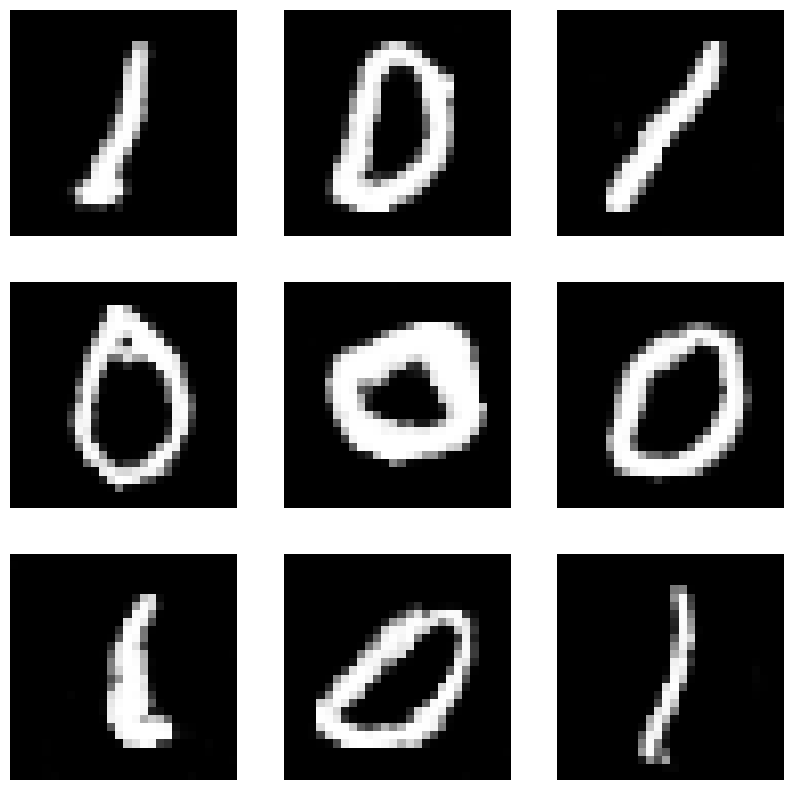

In [31]:
plot_images(gen_imgs)